In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [ ]:
# cd drive/My Drive/BTP

In [4]:
train_df=pd.read_csv(r'imputed_train_encoded_data.csv')
valid_df=pd.read_csv(r'imputed_valid_encoded_data.csv')

### Splitting the sequence into samples

In [5]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
from sklearn.preprocessing import MinMaxScaler

train_data=train_df.drop(['date'],axis='columns')
scalers={}

for i in range(1,588):
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train_data['unit'+str(i)].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler'+str(i)] = scaler
    train_data['unit'+str(i)]=s_s

valid_data=valid_df.drop(['date'],axis='columns')
for i in range(1,588):
    scaler = scalers['scaler'+str(i)]
    s_s = scaler.transform(valid_data['unit'+str(i)].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler'+str(i)] = scaler
    valid_data['unit'+str(i)]=s_s
    
    
n_steps_in, n_steps_out = 45, 7
n_features = 587

In [7]:
X_train, y_train = split_sequences(train_data.values,n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_valid, y_valid = split_sequences(valid_data.values,n_steps_in, n_steps_out)
X_valid = X_valid.reshape((X_valid.shape[0], X_train.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_train.shape[1], n_features))

X,y = np.concatenate([X_train,X_valid],axis=0),np.concatenate([y_train,y_valid],axis=0)

In [78]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [8]:
# E1D1
encoder_inputs = tf.keras.layers.Input(shape=(n_steps_in, n_features))
encoder_l1 = tf.keras.layers.LSTM(1000, return_state=True)
encoder_outputs = encoder_l1(encoder_inputs)
encoder_states = encoder_outputs[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_steps_out)(encoder_outputs[0])

decoder_l1 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_inputs,initial_state = encoder_states)
decoder_outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.Huber())

history=model_e1d1.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid),batch_size=384,verbose=1,callbacks=[reduce_lr])

model_e1d1.save('E1D1.h5')

# E2D1
encoder_inputs = tf.keras.layers.Input(shape=(n_steps_in, n_features))
encoder_l1 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(1000, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_steps_out)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e2d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e2d1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.Huber())

history=model_e2d1.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid),batch_size=384,verbose=1,callbacks=[reduce_lr])

model_e2d1.save('E2D1.h5')

# E2D2
encoder_inputs = tf.keras.layers.Input(shape=(n_steps_in, n_features))
encoder_l1 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(1000, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_steps_out)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
# decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
decoder_l2 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.Huber())

history=model_e2d2.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid),batch_size=384,verbose=1,callbacks=[reduce_lr])

model_e2d2.save('E2D2.h5')

# E3D2
encoder_inputs = tf.keras.layers.Input(shape=(n_steps_in, n_features))
encoder_l1 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

encoder_l3 = tf.keras.layers.LSTM(1000, return_state=True)
encoder_outputs3 = encoder_l3(encoder_outputs2[0])
encoder_states3 = encoder_outputs3[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_steps_out)(encoder_outputs3[0])

decoder_l1 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_inputs,initial_state = encoder_states2)
decoder_l2 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_l1,initial_state = encoder_states3)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e3d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e3d2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.Huber())

history=model_e3d2.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid),batch_size=384,verbose=1,callbacks=[reduce_lr])

model_e3d2.save('E3D2.h5')

# E3D3
encoder_inputs = tf.keras.layers.Input(shape=(n_steps_in, n_features))
encoder_l1 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(1000,return_sequences = True, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

encoder_l3 = tf.keras.layers.LSTM(1000, return_state=True)
encoder_outputs3 = encoder_l3(encoder_outputs2[0])
encoder_states3 = encoder_outputs3[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_steps_out)(encoder_outputs3[0])

decoder_l1 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_l3 = tf.keras.layers.LSTM(1000, return_sequences=True)(decoder_l2,initial_state = encoder_states3)
decoder_outputs3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l3)

model_e3d3 = tf.keras.models.Model(encoder_inputs,decoder_outputs3)

model_e3d3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.Huber())

history=model_e3d3.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid),batch_size=384,verbose=1,callbacks=[reduce_lr])

model_e3d3.save('E3D3.h5')


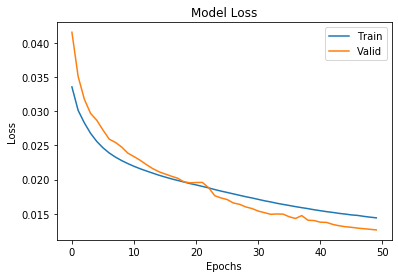

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0.03,0.035)
plt.legend(['Train', 'Valid'])
plt.show()
# plt.savefig('loss.png')

In [132]:
model_e1d1.load_weights('Models/TSF/E1D1.h5')
model_e2d2.load_weights('Models/TSF/E2D2.h5')
model_e2d1.load_weights('Models/TSF/E2D1.h5')
model_e3d2.load_weights('Models/TSF/E3D2.h5')
model_e3d3.load_weights('Models/TSF/E3D3.h5')

In [133]:
X_train, y_train = split_sequences(train_data.values,n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_valid, y_valid = split_sequences(valid_data.values,n_steps_in, n_steps_out)
X_valid = X_valid.reshape((X_valid.shape[0], X_train.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_train.shape[1], n_features))

In [134]:
pred=model_e3d3.predict(X_valid)

In [135]:
# # pred.shape
for i in range(1,588):
    # print(i)

    scaler = scalers['scaler'+str(i)]
    pred[:,:,i-1]=scaler.inverse_transform(pred[:,:,i-1])
    #     y_train[:,:,i-1]=scaler.inverse_transform(y_train[:,:,i-1])
    y_valid[:,:,i-1]=scaler.inverse_transform(y_valid[:,:,i-1])

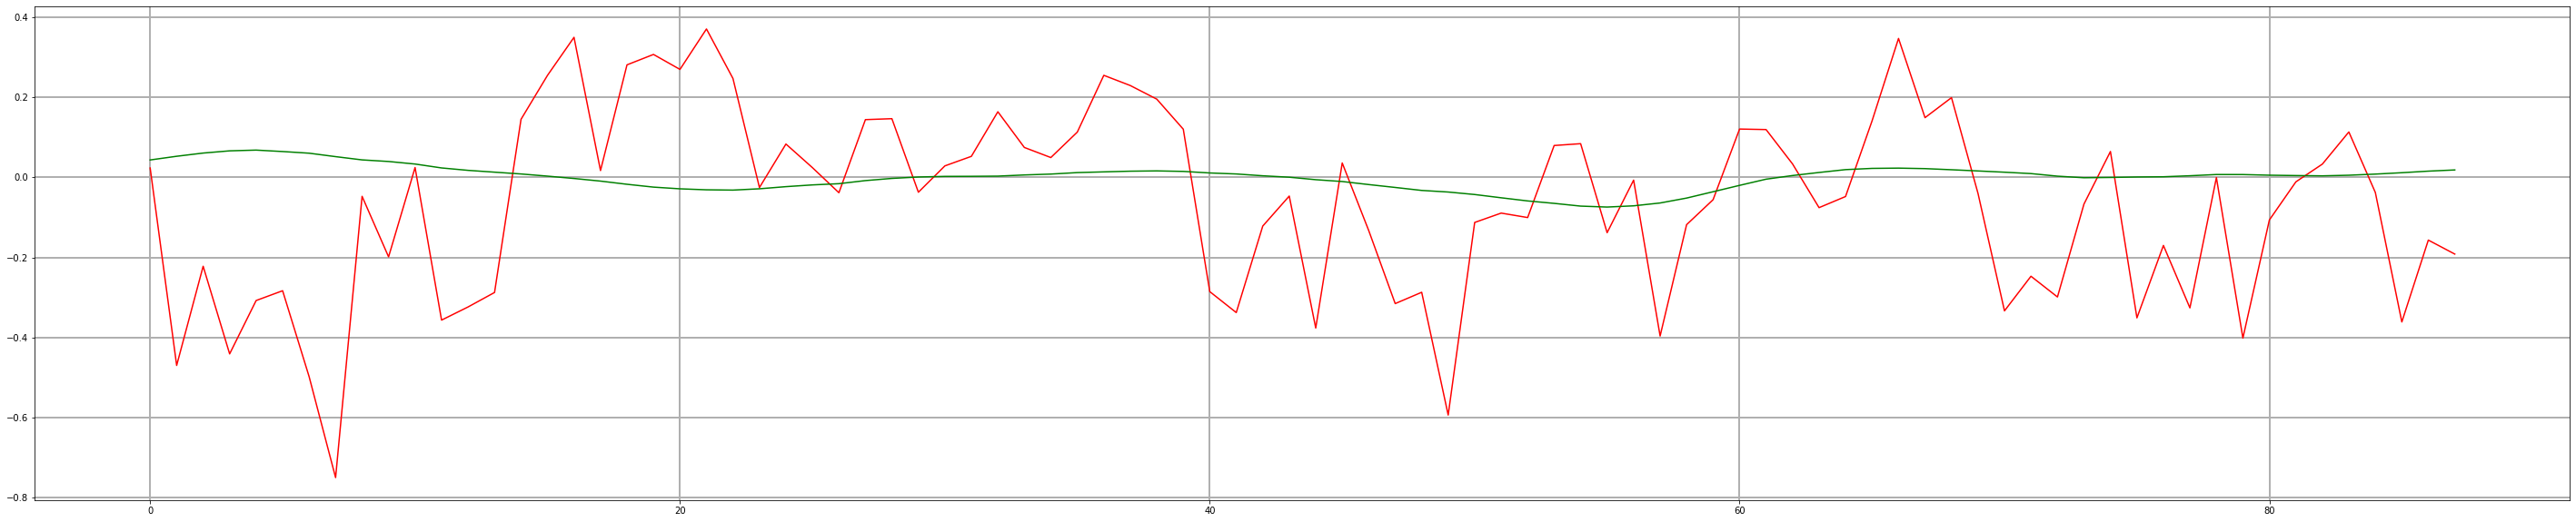

In [137]:
plt.figure(figsize=(50,10))

# plt.plot([x for x in y_train[:,0,510]],color='r')
plt.plot([x for x in y_valid[:,0,510]],color='r')
plt.plot([x for x in pred[:,0,510]],color='g')
# plt.plot([x for x in ddf.values[:,15]],color='b')
plt.grid(linestyle='-', linewidth=2)
plt.show()

In [138]:
daf1=valid_df.iloc[45:-6].reset_index(drop=True)
daf2=valid_df.iloc[46:-5].reset_index(drop=True)
daf3=valid_df.iloc[47:-4].reset_index(drop=True)
daf4=valid_df.iloc[48:-3].reset_index(drop=True)
daf5=valid_df.iloc[49:-2].reset_index(drop=True)
daf6=valid_df.iloc[50:-1].reset_index(drop=True)
daf7=valid_df.iloc[51:].reset_index(drop=True)
daf = [daf1,daf2,daf3,daf4,daf5,daf6,daf7]

In [139]:
for j in range(1,588):
    # print(j)
    for i in range(0,7):
        # print('\t',i)
        daf[i]['unit'+str(j)]=pred[:,i,j-1]    

In [140]:
for i,df in enumerate(daf):
    df.to_csv(r'Results/E3D3/'+str(i+1)+'.csv', index = False)    